# Analyse de données de films

Nous proposons de travailler sur des données décrivant des films. Les possibilités sont larges et vous êtes évalués sur vos propositions et votre méthodologie plus que sur vos résultats.

Les données de départ sont disponibles sur:
https://grouplens.org/datasets/movielens/
au format CSV. 

Nous nous intéresserons en particulier au jeu de données: **MovieLens 20M Dataset**. Dans ce jeu de données, vous disposez entre autre de:
* Idendifiant du film dans IMdb et TMdb (ça sera important ensuite)
* Catégorie(s) du film
* Titre du film
* Notes données par les internautes aux films

Afin de rendre le projet plus intéressant, nous ajoutons des données sur les acteurs et producteurs associés aux films (récupéré sur TMdb). Ces données sont disponibles sur les liens suivants:

http://webia.lip6.fr/~guigue/film_v2.pkl <br>
http://webia.lip6.fr/~guigue/act_v2.pkl <br>
http://webia.lip6.fr/~guigue/crew_v2.pkl

Ces fichiers contiennent respectivement : une nouvelle description des films (dont l'identifiant TMdb et la note moyenne donnée par les internautes, la date de sortie,...), une description des acteurs de chaque film et une description des équipes (scénariste, producteur, metteur en scène) pour chaque film.

Ces données sont des listes de taille 26908, chaque élément de la liste correspondant à un dictionnaire dont vous étudierez les clés pour récupérer les informations utiles.

**ATTENTION** Les contraintes de récupération d'informations en ligne font que la base MovieLens compte 27278 films mais les fichiers ci-dessus n'en comptent que 26908. Le plus simple est probablement d'éliminer les films de MovieLens qui ne sont pas dans cette seconde base.

## Consignes générales pour l'analyse des données

Vous devez proposer plusieurs analyses des données, qui devront à minima utiliser les
 techniques suivantes:
 
1. Mettre en forme les données pour identifier les acteurs et les catégories, les indexer
1. Traiter au moins un problème de régression supervisé (par exemple la prédiction de la note moyenne donnée à un film par les internautes).
1. Traiter au moins un problème de classification supervisé (par exemple la prédiction de la catégorie d'un film)
1. Utiliser les données catégorielles (catégories, acteurs,...) de manière discrète ET de manière coninue (*dummy coding*) dans des approches différentes
1. Proposer au moins une approche de catégorisation non supervisée (pour regrouper les acteurs par exemple)
1. Mener une campagne d'expérience permettant de comparer les performances sur un problème en fonction des valeurs d'un paramètre (et donc, in fine, trouver la meilleure valeur du paramètre)
1. Proposer quelques illustrations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle as pkl
import sys
import math
sys.path.append('../')
import iads as iads
from iads import LabeledSet as ls
from iads import Classifiers as cl
from iads import util_iads as ui
from iads import utils as ut
from iads import engineering as en

## Chargement des données (base MovieLens + enrichissements)

In [2]:
# Chargement des données MovieLens
movies = pd.read_csv("data/ml-20m/movies.csv", encoding='utf8')
#movies = pd.read_csv("data/ml-20m/moviesFiltree.csv", encoding='utf8', index_col=0)
links = pd.read_csv("data/ml-20m/links.csv", encoding='utf8')
ratings = pd.read_csv("data/ml-20m/ratings.csv", encoding='utf8')
tags = pd.read_csv("data/ml-20m/tags.csv", encoding='utf8')
genomeS = pd.read_csv("data/ml-20m/genome-scores.csv", encoding='utf8')
genomeT = pd.read_csv("data/ml-20m/genome-tags.csv", encoding='utf8')

In [3]:
# Chargement des données complémentaires
acteurs = pkl.load(open("data/act_v2.pkl", "rb"))
equipes = pkl.load(open("data/crew_v2.pkl", "rb"))
films = pkl.load(open("data/film_v2.pkl", "rb"))

<h2>Filtrage des données</h2>

In [4]:
print("BEFORE")
print(len(movies))
#print(len(films))
moviesFilter = []
filmId = []
cpt = 0
for i in range(len(films)):
    filmId.append(films[i]["id"])
    
for i in range(len(movies)):
    line = links.loc[links['movieId'] == movies.iloc[i]["movieId"]]
    value = float(line.iloc[0]["tmdbId"])
    if(math.isnan(value)):
        cpt += 1
        continue
    if(value in filmId):
        moviesFilter.append(movies.iloc[i]["movieId"])
    else:
        cpt += 1
movies = movies[movies.movieId.isin(moviesFilter)]
links = links[links.movieId.isin(moviesFilter)]
ratings = ratings[ratings.movieId.isin(moviesFilter)]
print("\nAFTER")
print(len(movies))
movies.to_csv("data/ml-20m/moviesFiltree.csv", encoding='utf8')

BEFORE
26699

AFTER
26699


<h2>Visionnage des données</h2>

In [5]:
#links
#ratings
#tags
#genomeS
#genomeT
#movies
#films[9]
#acteurs[0]
#equipes[0][194]

## Feature engineering
A vous de créer les caractéristiques de description des données qui permettront d'améliorer les performances dans les tâches que vous aurez choisi d'aborder dans le projet.

In [6]:
# Faire un dictionnaire avec tous les acteurs (acteur => indice)
# + un dictionnaire inversé (indice => acteur)
ue = en.UtilsEngineering(films, acteurs)
print("Tom Hanks à joué dans", ue.actorsPlayedMovies["Tom Hanks"]["Total"], "films")
print("Tom Hanks à joué dans", ue.actorsPlayedMovies["Tom Hanks"]["Comedy"], "comédies")

UtilsEngineering init in process
UtilsEngineering init successful
Tom Hanks à joué dans 57 films
Tom Hanks à joué dans 33 comédies


## Genres predictions
Faire un dataframe sur les categories, leur quantites de films et leur engagements puis le tester sur des classifiers afin de prédire la note moyenne des films de la categorie

In [7]:
ge = en.GenresEngineering(movies,(links, films))
df = ge.toDataFrame()
df.to_csv("data/engineering/genres.csv", encoding='utf8')
#df = pd.read_csv("data/engineering/genres.csv", encoding='utf8', index_col=0)
df

GenresEngineering init in process
GenresEngineering init successful
median 6.9247954829691185


,quantite,engagement,target
Adventure,0.160587,0.653805,-1
Animation,0.061394,0.234012,1
Children,0.072183,0.259724,-1
Comedy,0.625427,0.784191,-1
Fantasy,0.091354,0.347602,-1
Romance,0.299752,0.376248,-1
Drama,1.000000,1.000000,1
Action,0.253648,0.841496,-1
Crime,0.209329,0.394125,1
Thriller,0.305107,0.692253,-1


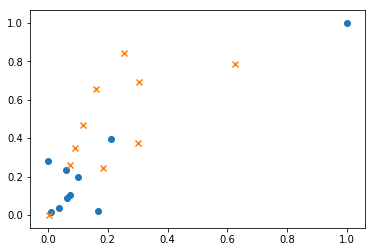

In [8]:
une_base = ls.LabeledSet(2)
for i in range(len(df)):
    une_base.addExample([df.iloc[i]['quantite'], df.iloc[i]['engagement']], df.iloc[i]['target'])
ut.plot2DSet(une_base)

No handles with labels found to put in legend.


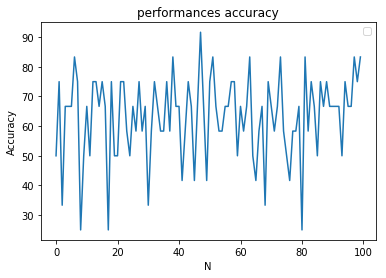

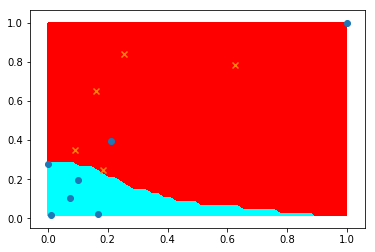

In [9]:
#ut.affiche_base(une_base)
knn = cl.ClassifierKNN(une_base.getInputDimension(), 3)
ut.super_entrainement(100, une_base, knn, 40)

## Movies prediction
Faire un dataFrame sur les films, le nombre de votes qu'ils on recuent, leur langue original, la note moyenne des films dans lesquels les acteurs principaux ont joués et leur popularité afin de prédire leur note

In [10]:
me = en.MoviesEngineering(films, (ue.plays, ue.actorsMeanMovies))
df = me.toDataFrame()
df

MoviesEngineering init in process
MoviesEngineering init successful
median 6.3


,vote_count,moy_main_actors,popularity,original_language,target
Toy Story,0.453466,0.653343,0.428418,en,1
Jumanji,0.265622,0.652299,0.055441,en,1
Grumpier Old Men,0.006648,0.633164,0.114305,en,1
Waiting to Exhale,0.002612,0.604392,0.054876,en,-1
Father of the Bride Part II,0.013675,0.605705,0.128245,en,-1
Heat,0.142545,0.333967,0.257092,en,1
Sabrina,0.012346,0.688355,0.116205,en,-1
Tom and Huck,0.003466,0.582065,0.067104,en,-1
Sudden Death,0.013248,0.598221,0.110806,en,-1
GoldenEye,0.087987,0.620224,0.312834,en,1
